In [1]:
import numpy as np

In [2]:
from definitions import path_join, make_directory, EXPERIMENTS_DIR, VENSIM_MODELS_DIR, logging, DATA_DIR

In [3]:
args = {
    'model_name': 'medical',
    'experiment_name': 'medical_modeling_new_prn',
    'need_retrain': False,
    'learning_rate': 1e-1,
    'epochs_before_decay': 0.1,
    'epochs_count': 10,
    'learning_rate_decay': 1/3,
#     'iterations_count': 300,
}

In [4]:
KNOWN_MODEL = 'unknown model'

In [5]:
import tensorflow as tf

general_params = \
    {
        'phi_h': tf.keras.activations.linear,
        'phi_o': tf.keras.activations.linear,
    }

train_params = \
    {
        'learning_rate': args['learning_rate'],
        'epochs_before_decay': args['epochs_before_decay'],
        'epochs_count': args['epochs_count'],
        'learning_rate_decay': args['learning_rate_decay'],
        'early_stopping_patience': 10,
    }


In [6]:
model_name = args['model_name']
need_train = bool(args['need_retrain'])
mode = KNOWN_MODEL

experiment_name = args['experiment_name']
experiment_dir = path_join(EXPERIMENTS_DIR, experiment_name)
make_directory(experiment_dir)

tf_model_dir = path_join(experiment_dir, 'tf_model')
make_directory(tf_model_dir)

images_dir = path_join(experiment_dir, 'images')
make_directory(images_dir)

log_path = path_join(experiment_dir, 'log.log')
logging.basicConfig(filename=log_path, level=logging.INFO)

vensim_model_file = path_join(VENSIM_MODELS_DIR, '{}.mdl'.format(model_name))

prn_model_dir = path_join(tf_model_dir, 'prn_model')
nn_model_dir = path_join(tf_model_dir, 'base_nn_model')
make_directory(prn_model_dir)
make_directory(nn_model_dir)

dataset_dir = path_join(DATA_DIR, model_name)
dataset_file_name = 'periodic_12H_time.csv'
dataset_file = path_join(dataset_dir, dataset_file_name)

In [7]:
import pandas as pd
from module.fd_model.vensim_fd_converter import create_unknown_model

data = pd.read_csv(dataset_file, delimiter='\t')
columns = data.columns
dt = data['timedelta'].values[1] - data['timedelta'].values[0]
stopwords = ['patient_id', 'epizod_id', 'start_date', 'end_date', 'data', 'activ', 'result', 'timedelta', 'event_timedelta', 'duration']
categorical_columns = ['sex', 'sd', 'activ', 'result', 'condition', 'Bleeding', 'Contrast-induced nephropathy', 'Stress-induced hyperglycemia', 'Systemic inflammatory response']

fields = [column for column in data.columns if column not in stopwords]

FD = create_unknown_model(fields)
FD.dT = dt

In [8]:
data.head()

,patient_id,epizod_id,start_date,end_date,data,sex,age,sd,activ,result,...,Holesterin,pressure,condition,timedelta,event_timedelta,duration,Bleeding,Contrast-induced nephropathy,Stress-induced hyperglycemia,Systemic inflammatory response
0,100026,429642,201503160000,201503170000,199901010000,1.0,82.0,0.0,0,1.0,...,1.39,115.00,2.0,17.33,0.0,105.32,0.0,0.0,0.0,0.0
1,100026,429642,201503160000,201503170000,199901010000,1.0,82.0,0.0,0,1.0,...,1.47,145.41,2.0,29.33,0.0,105.32,0.0,0.0,0.0,0.0
2,100026,429642,201503160000,201503170000,199901010000,1.0,82.0,0.0,0,1.0,...,1.48,132.50,2.0,41.33,0.0,105.32,0.0,0.0,0.0,0.0
3,100026,429642,201503160000,201503170000,199901010000,1.0,82.0,0.0,0,1.0,...,1.48,113.79,2.0,53.34,0.0,105.32,0.0,0.0,0.0,0.0
4,100026,429642,201503160000,201503170000,199901010000,1.0,82.0,0.0,0,1.0,...,1.48,120.12,2.0,65.33,0.0,105.32,0.0,0.0,0.0,0.0


In [9]:
fields

['sex',
 'age',
 'sd',
 'Troponin',
 'RBC',
 'WBC',
 'HGB',
 'HCT',
 'PLT',
 'AST',
 'ALT',
 'Kreatinin',
 'Glucose',
 'Holesterin',
 'pressure',
 'condition',
 'Bleeding',
 'Contrast-induced nephropathy',
 'Stress-induced hyperglycemia',
 'Systemic inflammatory response']

In [10]:
from sklearn.model_selection import train_test_split


def np_preproc_for_rnn3d(numpy_array, fields):
    x_groups = [group[1][fields].values[:-1] for group in numpy_array]
    y_groups = [group[1][fields].values[1:] for group in numpy_array]
    
    #     train_X, valid_X, train_y, valid_y = train_test_split(x_groups, y_groups, test_size=0.2, random_state=123)
    
    train_X = np.concatenate(x_groups, axis=0)
    train_y = np.concatenate(y_groups, axis=0)
    
    #     train_y = np.concatenate(train_y, axis=0)
    #     valid_y = np.concatenate(valid_y, axis=0)

    return (train_X, train_y)


def generate_train_data(df, fields):
    dataset = df[fields].values
    grouped = df.groupby(['patient_id', 'epizod_id'])[fields]
    
    return dataset, np_preproc_for_rnn3d(grouped, fields)

In [11]:
# categorical_columns = ['sex', 'sd', 'activ', 'result', 'condition', 'Bleeding', 'Contrast-induced nephropathy', 'Stress-induced hyperglycemia', 'Systemic inflammatory response']
# data[categorical_columns] += 1

In [12]:
fields

['sex',
 'age',
 'sd',
 'Troponin',
 'RBC',
 'WBC',
 'HGB',
 'HCT',
 'PLT',
 'AST',
 'ALT',
 'Kreatinin',
 'Glucose',
 'Holesterin',
 'pressure',
 'condition',
 'Bleeding',
 'Contrast-induced nephropathy',
 'Stress-induced hyperglycemia',
 'Systemic inflammatory response']

In [13]:
data[categorical_columns] += 1

In [14]:
train_ids, valid_ids = train_test_split(data['epizod_id'].unique(), test_size=0.2, random_state=123)
prn_train = data[data['epizod_id'].isin(train_ids)]
dataset, (prn_train_X, prn_train_y) = generate_train_data(prn_train, fields)

In [15]:
prn_valid = data[data['epizod_id'].isin(valid_ids)]
dataset, (prn_valid_X, prn_valid_y) = generate_train_data(prn_valid, fields)

In [16]:
prn_valid.iloc[8:26]

,patient_id,epizod_id,start_date,end_date,data,sex,age,sd,activ,result,...,Holesterin,pressure,condition,timedelta,event_timedelta,duration,Bleeding,Contrast-induced nephropathy,Stress-induced hyperglycemia,Systemic inflammatory response
104,100318,431375,201510040000,201510190000,201510061926,1.0,83.0,2.0,1,2.0,...,2.03,160.00,3.00,1.02,0.00,201.4,2.0,1.0,1.0,1.0
105,100318,431375,201510040000,201510190000,201510061926,1.0,83.0,2.0,1,2.0,...,2.03,160.00,3.00,13.02,0.00,201.4,2.0,1.0,1.0,1.0
106,100318,431375,201510040000,201510190000,201510061926,1.0,83.0,2.0,1,2.0,...,2.03,132.91,3.00,25.02,0.00,201.4,2.0,1.0,1.0,1.0
107,100318,431375,201510040000,201510190000,201510061926,1.0,83.0,2.0,1,2.0,...,2.03,118.72,3.00,37.02,0.00,201.4,2.0,1.0,1.0,1.0
108,100318,431375,201510040000,201510190000,201510061926,1.0,83.0,2.0,1,2.0,...,2.03,126.56,3.00,49.02,0.00,201.4,2.0,1.0,1.0,1.0
109,100318,431375,201510040000,201510190000,201510061926,1.0,83.0,2.0,1,2.0,...,2.03,125.86,3.00,61.02,1.29,201.4,2.0,1.0,1.0,1.0
110,100318,431375,201510040000,201510190000,201510061926,1.0,83.0,2.0,1,2.0,...,2.03,115.37,3.00,73.02,5.59,201.4,2.0,1.0,1.0,1.0
111,100318,431375,201510040000,201510190000,201510061926,1.0,83.0,2.0,1,2.0,...,2.03,120.07,3.00,85.01,17.58,201.4,2.0,1.0,1.0,1.0
112,100318,431375,201510040000,201510190000,201510061926,1.0,83.0,2.0,1,2.0,...,2.03,137.90,3.00,97.02,29.59,201.4,2.0,1.0,1.0,1.0
113,100318,431375,201510040000,201510190000,201510061926,1.0,83.0,2.0,1,2.0,...,2.03,138.30,2.73,109.02,41.58,201.4,2.0,1.0,1.0,1.0


In [17]:
prn_valid_X[:13, 1]

array([74., 74., 74., 74., 74., 74., 74., 74., 74., 74., 74., 74., 74.])

In [18]:
data.describe()

,patient_id,epizod_id,start_date,end_date,data,sex,age,sd,activ,result,...,Holesterin,pressure,condition,timedelta,event_timedelta,duration,Bleeding,Contrast-induced nephropathy,Stress-induced hyperglycemia,Systemic inflammatory response
count,289141.000000,2.891410e+05,2.891410e+05,2.891410e+05,2.891410e+05,289141.000000,289141.000000,289141.000000,289141.000000,289141.000000,...,289141.000000,289141.000000,289141.000000,289141.000000,289141.000000,289141.000000,289141.000000,289141.000000,289141.000000,289141.000000
mean,298972.060002,2.017949e+06,2.014213e+11,2.014249e+11,2.003192e+11,1.627753,61.468242,1.061959,1.016207,2.125378,...,1.552036,121.047909,2.504768,194.030516,41.773519,1496.748121,1.380109,1.006630,1.011036,1.344424
std,110972.428349,8.868309e+05,1.367666e+08,1.369389e+08,6.873189e+08,0.483405,11.914214,0.241082,0.126270,1.077740,...,0.353310,10.336723,0.586913,143.031935,96.898116,4324.349780,0.485414,0.081154,0.104472,0.475181
min,22302.000000,3.210000e+02,2.010050e+11,2.010062e+11,1.999010e+11,1.000000,25.000000,1.000000,1.000000,1.000000,...,0.500000,8.000000,2.000000,0.000000,0.000000,-63.230000,1.000000,1.000000,1.000000,1.000000
25%,232260.000000,1.459312e+06,2.013092e+11,2.013101e+11,1.999010e+11,1.000000,54.000000,1.000000,1.000000,2.000000,...,1.370000,116.180000,2.000000,81.750000,0.000000,176.970000,1.000000,1.000000,1.000000,1.000000
50%,316151.000000,2.144240e+06,2.014103e+11,2.014111e+11,1.999010e+11,2.000000,62.000000,1.000000,1.000000,2.000000,...,1.530000,120.530000,2.230000,158.620000,0.000000,345.200000,1.000000,1.000000,1.000000,1.000000
75%,391934.000000,2.775889e+06,2.015102e+11,2.015110e+11,2.013012e+11,2.000000,69.000000,1.000000,1.000000,2.000000,...,1.720000,126.020000,3.000000,275.750000,1.610000,633.350000,2.000000,1.000000,1.000000,2.000000
max,466755.000000,3.339093e+06,2.016060e+11,2.016061e+11,2.016053e+11,2.000000,95.000000,2.000000,2.000000,20.000000,...,3.850000,160.000000,5.000000,720.000000,707.650000,48657.630000,2.000000,2.000000,2.000000,2.000000


In [19]:
_test = np.log(prn_train_X)

In [20]:
np.isinf(_test).sum() + np.isnan(_test).sum()

0

In [21]:
import tensorflow as tf
from tensorflow.python.framework import ops

ops.reset_default_graph()

In [22]:
from module.fd_model.fd_rnn_converter import FDRNNConverter
# from module.nn_model import NNModel as NNModelv1
from module.nn_model_tf_v2 import NNModel as NNModelv2
# from module.nn_model_with_regularizer import NNModel as NNModelv3
from module.nn_model_tf_v3 import NNModel as NNModelv3
from module.nn_model_tf_v21 import NNModel as NNModelv21

choosed_model = NNModelv2

In [23]:
FDRNN_converter = FDRNNConverter(general_params['phi_h'], general_params['phi_o'])
rnn_model = FDRNN_converter.fd_to_rnn(FD, choosed_model)

In [24]:
FD.levels

['sex',
 'age',
 'sd',
 'Troponin',
 'RBC',
 'WBC',
 'HGB',
 'HCT',
 'PLT',
 'AST',
 'ALT',
 'Kreatinin',
 'Glucose',
 'Holesterin',
 'pressure',
 'condition',
 'Bleeding',
 'Contrast-induced nephropathy',
 'Stress-induced hyperglycemia',
 'Systemic inflammatory response']

In [25]:
FD.constants

[]

In [26]:
FD.rates

[rate : in_sex
 flow : start : None,	end : sex
 
 sex : 1
 age : 1
 sd : 1
 Troponin : 1
 RBC : 1
 WBC : 1
 HGB : 1
 HCT : 1
 PLT : 1
 AST : 1
 ALT : 1
 Kreatinin : 1
 Glucose : 1
 Holesterin : 1
 pressure : 1
 condition : 1
 Bleeding : 1
 Contrast-induced nephropathy : 1
 Stress-induced hyperglycemia : 1
 Systemic inflammatory response : 1
 , rate : out_sex
 flow : start : sex,	end : None
 
 sex : 1
 age : 1
 sd : 1
 Troponin : 1
 RBC : 1
 WBC : 1
 HGB : 1
 HCT : 1
 PLT : 1
 AST : 1
 ALT : 1
 Kreatinin : 1
 Glucose : 1
 Holesterin : 1
 pressure : 1
 condition : 1
 Bleeding : 1
 Contrast-induced nephropathy : 1
 Stress-induced hyperglycemia : 1
 Systemic inflammatory response : 1
 , rate : in_age
 flow : start : None,	end : age
 
 sex : 1
 age : 1
 sd : 1
 Troponin : 1
 RBC : 1
 WBC : 1
 HGB : 1
 HCT : 1
 PLT : 1
 AST : 1
 ALT : 1
 Kreatinin : 1
 Glucose : 1
 Holesterin : 1
 pressure : 1
 condition : 1
 Bleeding : 1
 Contrast-induced nephropathy : 1
 Stress-induced hyperglycemia : 1
 S

In [27]:
rate_names = [rate.name for rate in FD.rates]

In [28]:
prn_train_X[0]

array([2.0000e+00, 7.8000e+01, 1.0000e+00, 2.0000e-01, 4.9100e+00,
       6.3000e+00, 1.4100e+02, 4.3900e+01, 2.6700e+02, 2.4700e+01,
       2.6600e+01, 1.0949e+02, 7.3100e+00, 2.0000e+00, 1.2500e+02,
       2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00])

In [29]:
if need_train:
    rnn_model.train(prn_train_X, prn_train_y, (prn_valid_X, prn_valid_y), train_params, prn_model_dir)

Train on 218108 samples, validate on 54490 samples
Epoch 1/10
218108/218108 [==============================] - 19s 86us/sample - loss: 29.0094 - mse: 29.0094 - val_loss: 31.1868 - val_mse: 31.1868
Epoch 2/10
218108/218108 [==============================] - 18s 84us/sample - loss: 28.9261 - mse: 28.9261 - val_loss: 31.1142 - val_mse: 31.1142
Epoch 3/10
218108/218108 [==============================] - 18s 83us/sample - loss: 28.9278 - mse: 28.9278 - val_loss: 31.0659 - val_mse: 31.0659
Epoch 4/10
218108/218108 [==============================] - 18s 80us/sample - loss: 28.9142 - mse: 28.9142


KeyboardInterrupt: 

In [29]:
rnn_model.load(prn_model_dir)

In [30]:
iterations_count = 29
# prn_valid_X[:29]

In [31]:
import tensorflow as tf

In [32]:
def parse_weights(gate, w, fields, rate_names):
    eps = 1e-4
    equations = []
    for col_idx in range(gate.shape[1]):
        equation = ''
        for row_idx in range(gate.shape[0]):
            if (np.abs(w[row_idx, col_idx]) - eps < 0):
                continue
            if gate[row_idx, col_idx] == 0:
                if w[row_idx, col_idx] > 0:
                    sign = '*' # if w[row_idx, col_idx] > 0 else '/'
                    weight = np.abs(w[row_idx, col_idx])
                    if weight == 1:
                        equation += '{}{}'.format(sign, fields[row_idx])
                    else:
                        equation += '{}{}^{:.1f}'.format(sign, fields[row_idx], weight)
                else:
                    continue
        for row_idx in range(gate.shape[0]):
            if (np.abs(w[row_idx, col_idx]) - eps < 0):
                continue
            if gate[row_idx, col_idx] == 0:
                if w[row_idx, col_idx] <= 0:
                    sign = '/' # if w[row_idx, col_idx] > 0 else '/'
                    weight = np.abs(w[row_idx, col_idx])
                    if weight == 1:
                        equation += '{}{}'.format(sign, fields[row_idx])
                    else:
                        equation += '{}{}^{:.1f}'.format(sign, fields[row_idx], weight)
                else:
                    continue
        for row_idx in range(gate.shape[0]):
            if (w[row_idx, col_idx] == 0):
                continue
            if gate[row_idx, col_idx] == 1:
                sign = '+' if w[row_idx, col_idx] > 0 else '-'
                weight = np.abs(w[row_idx, col_idx])
                if weight == 1:
                    equation += '{}{}'.format(sign, fields[row_idx])
                else:
                    equation += '{}{:.1f}{}'.format(sign, weight, fields[row_idx])

        equations.append((rate_names[col_idx], equation[1:]))
    return equations

In [33]:
def my_tf_round(x, decimals = 0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.math.round(x * multiplier) / multiplier

In [34]:
_gate = np.array(my_tf_round(rnn_model.model.gate, 0), dtype=np.float32)
_w = np.array(my_tf_round(rnn_model.model.W_ah, 2), dtype=np.float32)
# print(fields)
parse_weights(_gate, _w, fields, rate_names)

[('in_sex', ''),
 ('out_sex', ''),
 ('in_age', ''),
 ('out_age', ''),
 ('in_sd', ''),
 ('out_sd', ''),
 ('in_Troponin',
  'sex^0.1*Troponin^0.3*Holesterin^0.2*Bleeding^0.0/sd^0.2/RBC^0.3/WBC^0.1/Glucose^0.2/condition^0.3/Stress-induced hyperglycemia^0.0/Systemic inflammatory response^0.0'),
 ('out_Troponin',
  'Troponin^0.1*AST^0.0*Holesterin^0.0*condition^0.2*Contrast-induced nephropathy^0.0*Stress-induced hyperglycemia^0.0*Systemic inflammatory response^0.0/sex^0.1/RBC^0.2/WBC^0.1/Glucose^0.2/Bleeding^0.0'),
 ('in_RBC', 'RBC^0.4/condition^0.1/Bleeding^0.0'),
 ('out_RBC', 'RBC^0.4/condition^0.1'),
 ('in_WBC',
  'WBC^0.0*Stress-induced hyperglycemia^0.0*Systemic inflammatory response^0.0/sd^0.0/RBC^0.3/condition^0.1'),
 ('out_WBC',
  'sd^0.0/sex^0.0/RBC^0.3/WBC^0.1/condition^0.0/Bleeding^0.0/Systemic inflammatory response^0.0'),
 ('in_HGB',
  'sex^0.1*WBC^0.0*HGB^0.0*HCT^0.0/sd^0.0/RBC^0.0/Kreatinin^0.0/Holesterin^0.1/condition^0.0/Bleeding^0.1/Contrast-induced nephropathy^0.0/Stress-i

In [35]:
_gate

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 

In [36]:
_w

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.06, -0.05,  0.  ,
         0.  ,  0.  , -0.01,  0.06, -0.01,  0.01, -0.02,  0.06,  0.02,
        -0.03, -0.03,  0.03, -0.09,  0.04,  0.  ,  0.  ,  0.02,  0.  ,
         0.  , -0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        -0.01,  0.  ,  0.02, -0.02, -0.05,  0.  , -0.01,  0.01,  0.  ,
         0.  , -0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.16,  0.  ,  0.  ,
         0.  , -0.01,  0.01, -0.01,  0.01,  0.  ,  0.  ,  0.01, -0.03,
         0.01, -0.01,  0.  ,  0.01, -0.04,  0.01,  0.07, -0.01,  0.  ,
         0.  ,  0.01, -0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  

In [37]:
tf.round(tf.math.sigmoid(rnn_model.model.gate))

<tf.Tensor: shape=(20, 40), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0

In [38]:
rnn_model.model.W_ah

<tf.Variable 'W_ah:0' shape=(20, 40) dtype=float32, numpy=
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.81581555e-02, -5.38903549e-02,  1.79254828e-04,
        -7.13637564e-06,  3.53952358e-03, -5.60321286e-03,
         6.01333939e-02, -6.53005764e-03,  1.23627046e-02,
        -2.09055953e-02,  6.36036098e-02,  1.62832085e-02,
        -2.86514945e-02, -3.10306996e-02,  2.58856695e-02,
        -8.93603936e-02,  3.83641087e-02, -2.69750529e-03,
        -2.60408444e-04,  1.53442165e-02, -2.06712680e-03,
         1.93999219e-03, -6.10464159e-03,  3.54859675e-03,
        -3.25550383e-04,  1.07051979e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -4.15748311e-03,  2.37

In [39]:
tf.round(rnn_model.model.W_ah)

<tf.Tensor: shape=(20, 40), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0

In [40]:
fields

['sex',
 'age',
 'sd',
 'Troponin',
 'RBC',
 'WBC',
 'HGB',
 'HCT',
 'PLT',
 'AST',
 'ALT',
 'Kreatinin',
 'Glucose',
 'Holesterin',
 'pressure',
 'condition',
 'Bleeding',
 'Contrast-induced nephropathy',
 'Stress-induced hyperglycemia',
 'Systemic inflammatory response']

In [41]:
initial_value = np.reshape(prn_valid_X[0], [1, prn_valid_X.shape[1]])
initial_value

array([[  1.  ,  74.  ,   1.  ,   4.37,   4.  ,   8.09, 116.53,  35.76,
        220.45,  20.  ,  11.  ,  67.86,   6.61,   1.53, 129.44,   3.  ,
          1.  ,   1.  ,   1.  ,   2.  ]])

In [42]:
iterations_count = 13

In [43]:
prn_iterative = rnn_model.get_simulation(initial_value, iterations_count, prn_model_dir)

In [44]:
prn_iterative.shape

(14, 20)

In [46]:
rw_images_dir = 'C:/Users/HWer/Desktop/4_sem_final_omg_3/'

In [47]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

c:\users\hwer\appdata\local\programs\python\python36\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

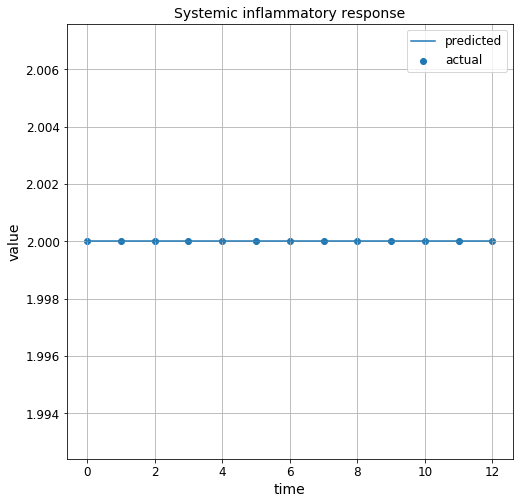

In [49]:
import matplotlib.pyplot as plt

for i in range(len(fields)):
    plt.clf()

    plt.figure(figsize=(8, 8))
    column = i

    title = fields[column]
    plt.title(title)
    plt.xlabel('time')
    plt.ylabel('value')
    plt.scatter(range(iterations_count), prn_valid_y[:iterations_count, column], label='actual')
    plt.plot(prn_iterative[1:, column], label='predicted')
    # plt.plot(nn_iterative[:, column], label='nn')
    plt.grid()
    plt.legend()
    plt.savefig(rw_images_dir + title + '.png')

In [44]:
def biplot(x, y, title, model_name, images_dir):
    plt.figure(figsize=(8, 8))
    plt.scatter(x, y)
    plt.grid()

#     min_ylim = min(min(x), min(y))
#     max_ylim = max(max(x), max(y))

#     plt.ylim(min_ylim, max_ylim)

    plt.xlabel('y')
    plt.ylabel('predicted')
    plt.title(title)

    # plt.show()
    image_path = path_join(images_dir, title + '.png')
    plt.savefig(image_path)
#     plt.gcf().clear()

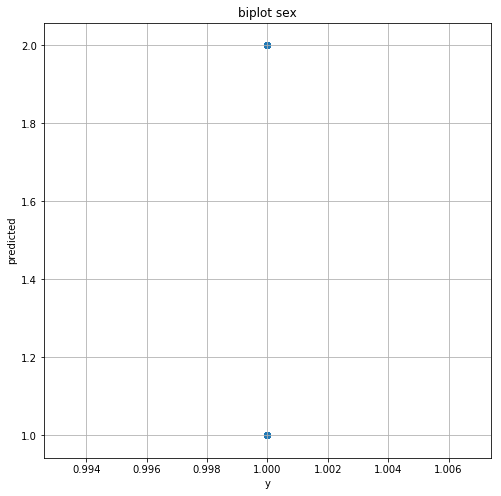

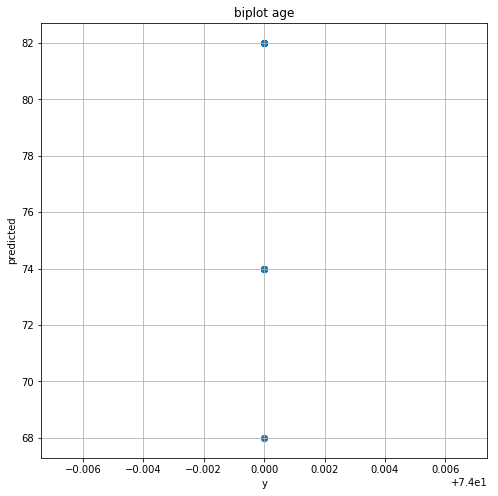

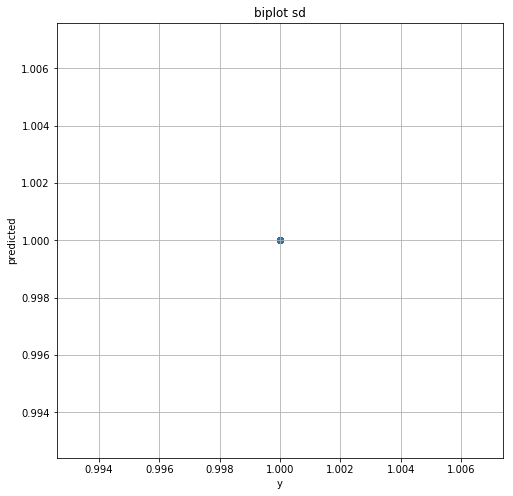

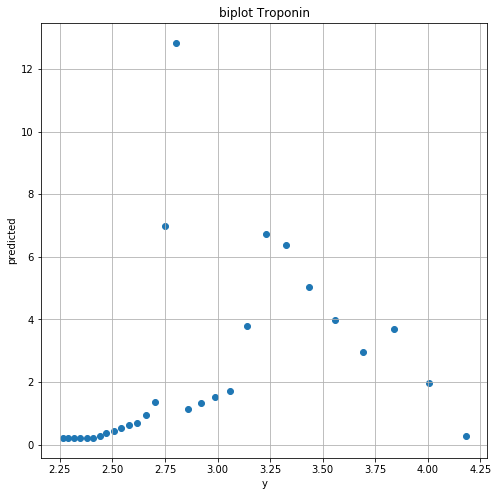

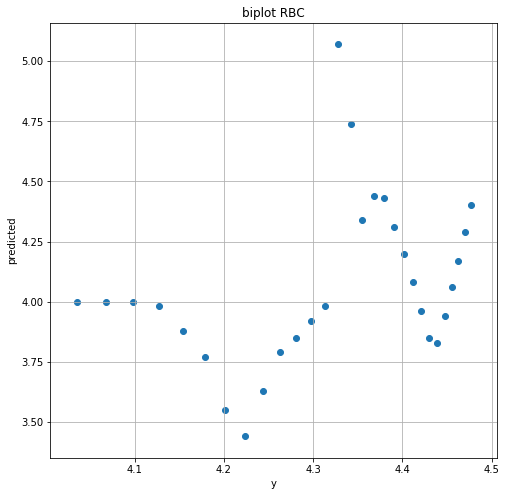

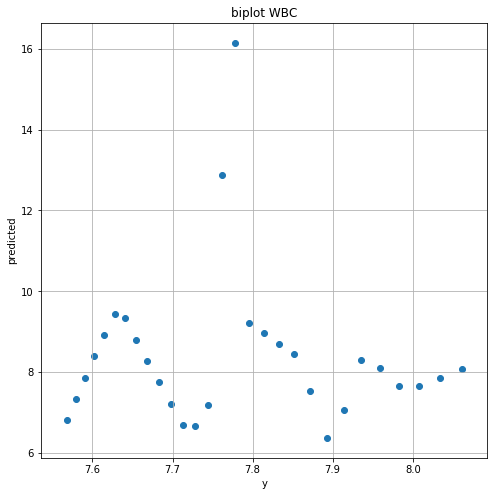

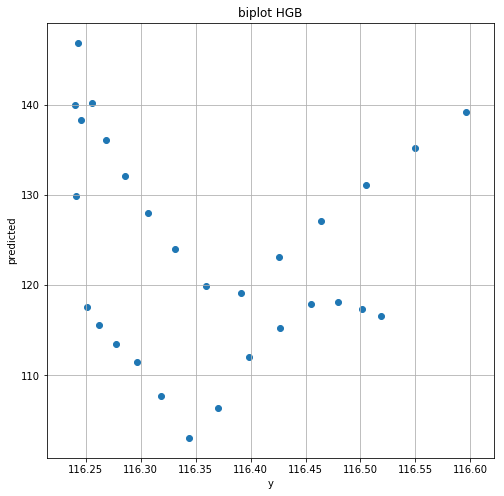

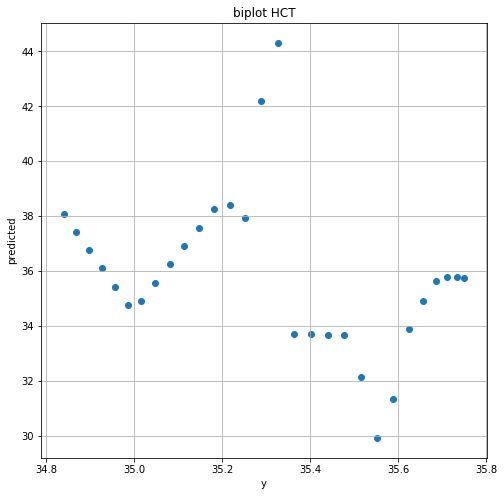

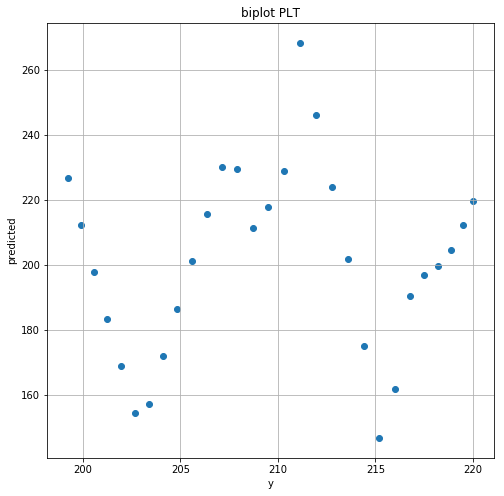

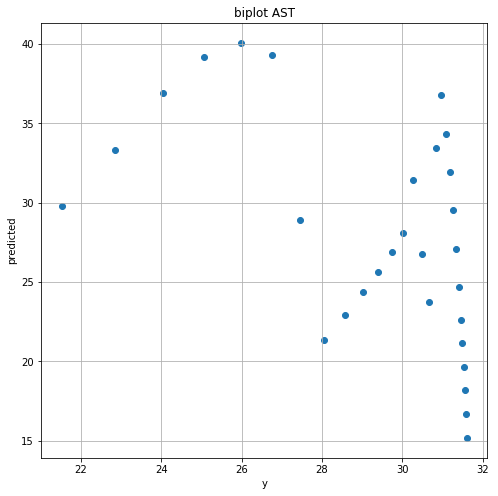

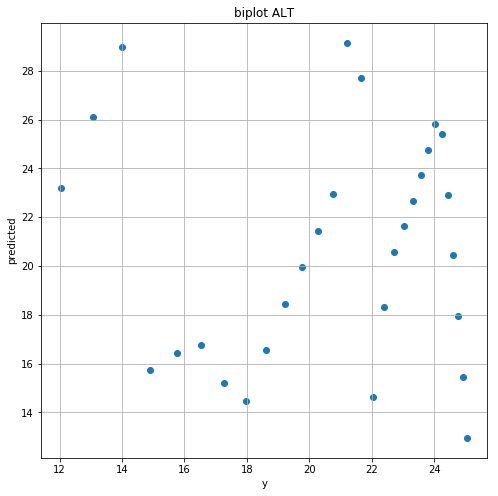

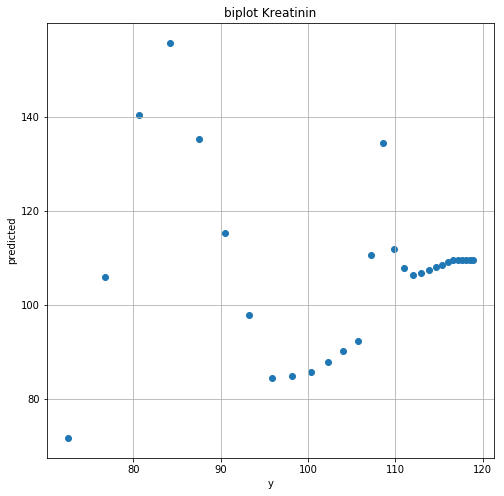

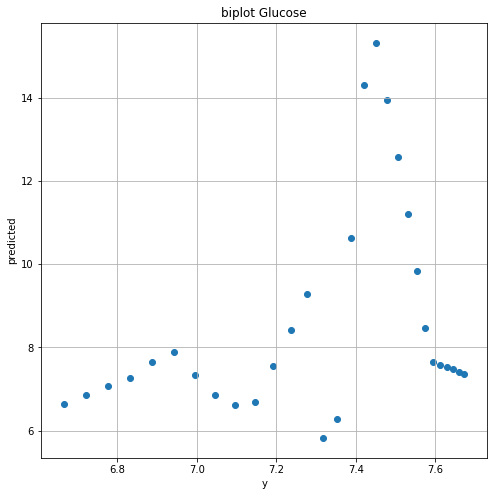

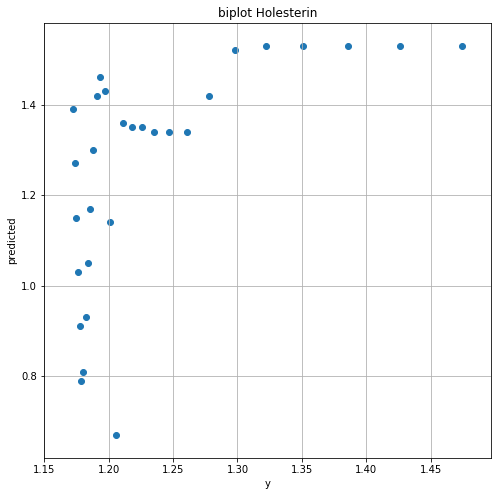

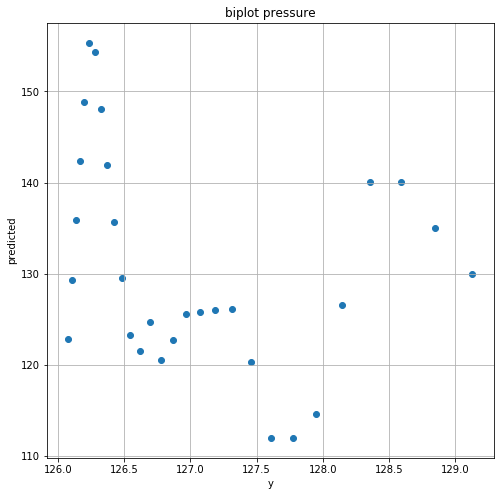

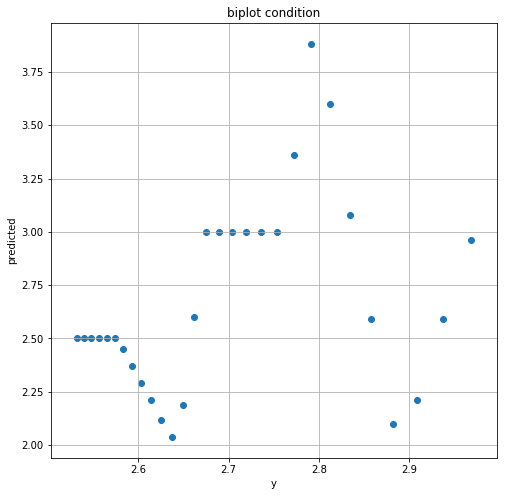

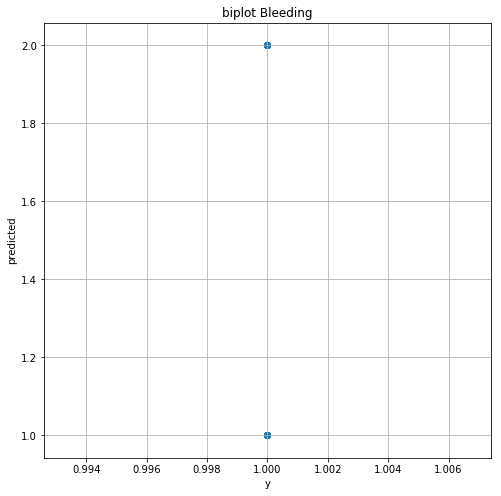

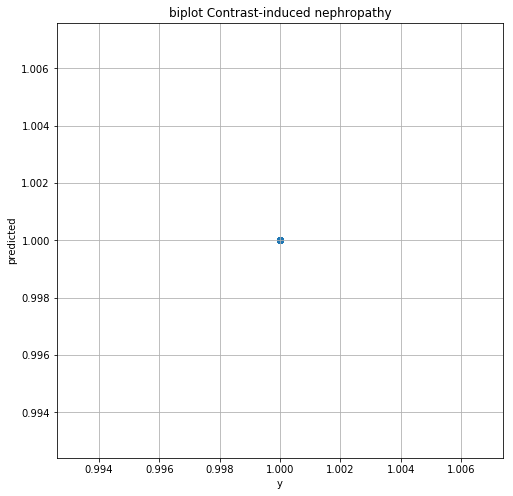

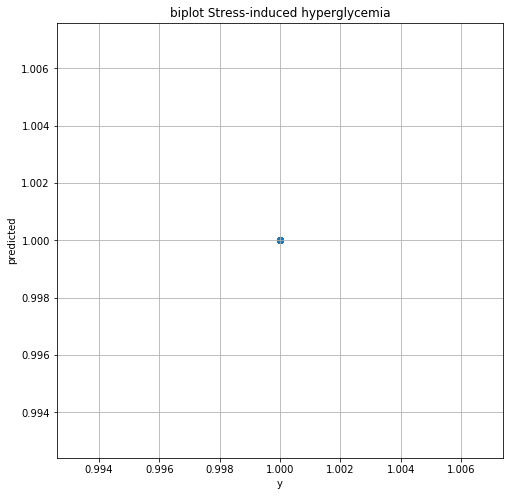

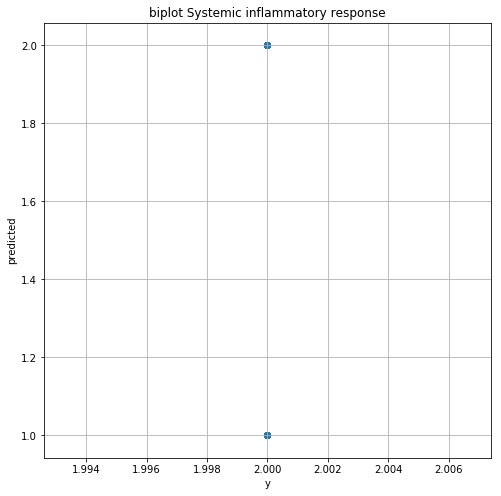

In [45]:
for level in fields:
    i = fields.index(level)
    level_output = prn_iterative[1:, i]
    level_y = prn_valid_y[:iterations_count, i]

    graphs = (level_output, level_y)
    labels = ('PRN_y', 'true_y')

    biplot_name2 = 'biplot {}'.format(level)
    biplot(level_output, level_y, biplot_name2, 'PRN', rw_images_dir)

In [46]:
from tensorboard import notebook
notebook.list()

No known TensorBoard instances running.


In [47]:
notebook.display(port=6006, height=1000)

In [48]:
import pickle

file_name = path_join(prn_model_dir, 'loss_history')
print(file_name)
with open(file_name, 'rb') as file:
    prn_train_data = pickle.load(file)

print(prn_train_data.keys())

C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\medical_modeling_new_prn\tf_model\prn_model\loss_history
dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


In [49]:
import os

[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


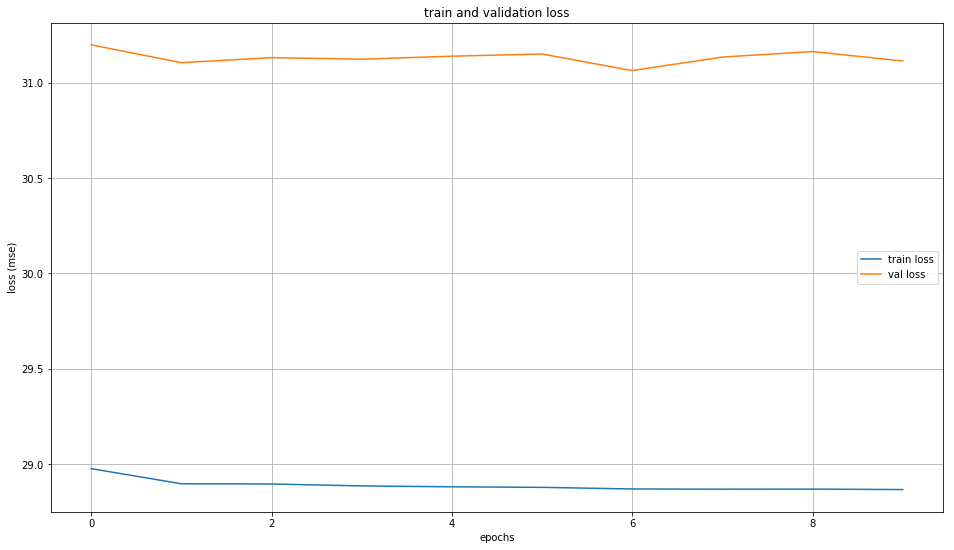

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.plot(prn_train_data['loss'], label='train loss')
plt.plot(prn_train_data['val_loss'], label='val loss')
plt.ylabel('loss (mse)')
plt.xlabel('epochs')
# plt.title('PRN and NN train loss')
# plt.ylim(0, 0.5)
y_ticks = [10 ** i for i in range(-10, 5)]
print(y_ticks)
# plt.yticks(y_ticks)
title = 'train and validation loss'
plt.title(title)
# plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig(os.path.join(rw_images_dir, title))